
# Тестовое задание:
---

Требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.

Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.

Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn import metrics

from sklearn.model_selection import train_test_split
from collections import defaultdict

rand_state = 42

In [2]:
train_data = pd.read_csv('dataset/train.tsv', sep = '\t')
#print(train_data['is_fake'].value_counts())
#train_data.style.hide_index()
train_data

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1
...,...,...
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0
5754,Правительство застроит Россию нефтепродуктопро...,0
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1
5756,Туркмения в декабре начнет поставки газа в Китай,0


---
# 1. Предобработка заголовков:

1) Из исходных заголовоков уберём все стоп-слова, несущие мало смысла (что, чтобы, как итд..)

2) Приведём каждое оставшееся слово к лемме (языковой единице в инфинитиве)

3) Применим подход TF-IDF


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def preprocessing(df):
    
    '''df = any given DataFrame with title names'''
    
    len_df = len(df)
    
    # удаление стоп слов:
    stop_words = set(stopwords.words('russian'))
    
    for i in range(len_df):

        words = word_tokenize(df['title'][i].lower())
        wordsFiltered = []

        for w in words:
            if w not in stop_words:
                wordsFiltered.append(w)

        df['title'][i] = " ".join(wordsFiltered)

        
    # лемматизация:
    morph = MorphAnalyzer()

    for i in range(len_df):

        title_words = word_tokenize(df['title'][i])
        lemmatized_title = []

        for word in title_words:

            p = morph.parse(word)[0]
            lemmatized_title.append(p.normal_form)

        df['title'][i] = " ".join(lemmatized_title)
        
    # В ходе исслаодвания также пробовал стеммер nltk.stem.snowball.SnowballStemmer, 
    # Он давал схожую точность, но не всегда верно обрабатывал слова (Навальный -> Навальн итд)
    
    return df

train_data = preprocessing(train_data)
train_data

,title,is_fake
0,москвич владимир клутина прийти счёт вмешатель...,1
1,агент кокорин назвать езда встречка житейский ...,0
2,госдума рассмотреть возможность введение секре...,1
3,фас заблокировать поставка скоростной трамвай ...,0
4,против навальный завести дело недоносительство...,1
...,...,...
5753,эдди чемберс получить сотрясение мозг бой кличко,0
5754,правительство застроить россия нефтепродуктопр...,0
5755,« стыдно дед » : новый канцлер фрг обратиться ...,1
5756,туркмения декабрь начать поставка газ китай,0


In [5]:
# TF-IDF (Токенизируем данные и строим словарь всех известных слов):

vectorizer = TfidfVectorizer()
train_x_vect = vectorizer.fit_transform(train_data['title'])
y_train = train_data['is_fake']

tmp = train_x_vect.toarray().shape
print('по всем {0} сообщениям набралось {1} уникальных слов'.format(tmp[0], tmp[1]))

по всем 5758 сообщениям набралось 11010 уникальных слов


---
# 2. Модель SVC (Support Vector Classifier):

In [6]:
# Метод опорных векоторов с линейным ядром - выберем оптимальный параметр штрафа перебором:
cv = KFold(n_splits = 5, shuffle = True, random_state = rand_state)
clf = SVC(kernel = 'linear', random_state = rand_state)

grid_svc_lin = {'C': np.linspace(0.5, 1.5, 11)}
gs_svc_lin = GridSearchCV(clf, grid_svc_lin, scoring = 'f1', cv = cv)
gs_svc_lin.fit(train_x_vect, y_train)

print('Max f1 score: {}'.format(gs_svc_lin.best_score_))
print('Parameter for this score: {}'.format(gs_svc_lin.best_params_))

Max f1 score: 0.8469072905979516
Parameter for this score: {'C': 0.9}


In [7]:
# Луший линейный классификатор:
svc_clf_lin = SVC(kernel = 'linear', C = gs_svc_lin.best_params_['C'], random_state = rand_state)
svc_clf_lin.fit(train_x_vect, y_train)

# Топ 20 самых значимых слов:
A = svc_clf_lin.coef_.indices
B = np.abs(svc_clf_lin.coef_.data)
most_important_words = A[B.argsort()[-20:][::-1]]

print('Top 20 most important words for this model: \n')
for i in most_important_words:
    print('{}'.format(vectorizer.get_feature_names()[i]))

Top 20 most important words for this model: 

навальный
гражданин
байден
роскосмос
который
млн
лукашенко
запретить
рпц
нобелевский
нефть
дмитрий
россиянин
право
коронавирус
сколково
обязать
выборы
госдума
футболист


In [8]:
# Попробуем метод с полиномиальным ядром.
# Также будем выбирать оптимальные параиметры перебором:

svc_grid_poly = {'degree': np.arange(1, 5), 'C': np.logspace(-1, 1, 10)}
clf = SVC(kernel = 'poly', random_state = rand_state)

gs_svc_poly = GridSearchCV(clf, svc_grid_poly, scoring = 'f1', cv = cv)
gs_svc_poly.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_svc_poly.best_score_))
print('parameters for this score: {}\n'.format(gs_svc_poly.best_params_))

max f1 score: 0.853397212805697
parameters for this score: {'C': 2.1544346900318834, 'degree': 2}



In [9]:
# Полиномиальная модель даёт лучшие результаты по метрике f1.
# Строим новую модель на лучших парметрах:
svc_clf = SVC(kernel = 'poly', 
              C = gs_svc_poly.best_params_['C'],
              degree = gs_svc_poly.best_params_['degree'],
              random_state = rand_state)
svc_clf.fit(train_x_vect, y_train)

# Ответ на тестовых данных:
test_data = pd.read_csv('dataset/test.tsv', sep = '\t')
test_data = preprocessing(test_data)
test_data['is_fake'] = svc_clf.predict(vectorizer.transform(test_data['title']))

#test_data.style.hide_index()
test_data.head(10)

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,1
1,ночью минский президентский гора беларашмор ( ...,1
2,бывший спичрайтер юрий лоза рассказать труднос...,1
3,"сельский церковь , собрать рекордно низкий кол...",1
4,акция google рухнуть объявление перезапуск rutube,0
5,курс доллар вырасти исторический максимум,0
6,опек назвать оптимальный уровень цена нефть,0
7,российский авиакомпания открыть рейс тбилиси урал,0
8,швейцарский горнолыжница расстрелять дом родитель,1
9,учредить театральный премия имя гарольд пинтер,0




---

# 3. Модель RF (Random Forest):

In [13]:
# Подбираем лучшие параметры:

grid_rfc = {'n_estimators': np.arange(150, 200, 5), 'max_depth': np.arange(5, 25)}
clf = RFC(random_state = rand_state)

gs_rfc = GridSearchCV(clf, grid_rfc, scoring = 'f1', cv = cv)
gs_rfc.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_rfc.best_score_))
print('params for this score: {}'.format(gs_rfc.best_params_))

max f1 score: 0.7699137080007756
params for this score: {'max_depth': 23, 'n_estimators': 175}



In [14]:
# Лучшая модель:
rfc_clf = RFC(n_estimators = gs_rfc.best_params_['n_estimators'],
              max_depth = gs_rfc.best_params_['max_depth'], 
              random_state = rand_state)
rfc_clf.fit(train_x_vect, y_train)

# Ответ на тестовых данных:
test_data = pd.read_csv('dataset/test.tsv', sep = '\t')
test_data = preprocessing(test_data)
test_data['is_fake'] = rfc_clf.predict(vectorizer.transform(test_data['title']))

#test_data.style.hide_index()
test_data.head(10)

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,1
1,ночью минский президентский гора беларашмор ( ...,1
2,бывший спичрайтер юрий лоза рассказать труднос...,0
3,"сельский церковь , собрать рекордно низкий кол...",0
4,акция google рухнуть объявление перезапуск rutube,0
5,курс доллар вырасти исторический максимум,0
6,опек назвать оптимальный уровень цена нефть,0
7,российский авиакомпания открыть рейс тбилиси урал,0
8,швейцарский горнолыжница расстрелять дом родитель,1
9,учредить театральный премия имя гарольд пинтер,0


---
# 4. Модель kNN (k Nearest Neighbours):

In [15]:
# Подбираем лучшие параметры:

grid_knn = {'n_neighbors': np.arange(5, 25)}
clf = KNN()

gs_knn = GridSearchCV(clf, grid_knn, scoring = 'f1', cv = cv)
gs_knn.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_knn.best_score_))
print('params for this score: {}\n'.format(gs_knn.best_params_))

max f1 score: 0.80532115666052
params for this score: {'n_neighbors': 19}



In [16]:
# Лучшая модель:
knn_clf = KNN(n_neighbors = gs_knn.best_params_['n_neighbors'])
knn_clf.fit(train_x_vect, y_train)

# Ответ на тестовых данных:
test_data = pd.read_csv('dataset/test.tsv', sep = '\t')
test_data = preprocessing(test_data)
test_data['is_fake'] = knn_clf.predict(vectorizer.transform(test_data['title']))

#test_data.style.hide_index()
test_data.head(10)

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,1
1,ночью минский президентский гора беларашмор ( ...,1
2,бывший спичрайтер юрий лоза рассказать труднос...,1
3,"сельский церковь , собрать рекордно низкий кол...",0
4,акция google рухнуть объявление перезапуск rutube,0
5,курс доллар вырасти исторический максимум,0
6,опек назвать оптимальный уровень цена нефть,0
7,российский авиакомпания открыть рейс тбилиси урал,0
8,швейцарский горнолыжница расстрелять дом родитель,1
9,учредить театральный премия имя гарольд пинтер,1


---
# 5. Модель MNB (Multinomial Naive Bayes):

In [17]:
# Подбираем лучшие параметры:

grid_mnb = {'alpha': np.linspace(0.5, 1.5, 21)}
clf = MNB()

gs_mnb = GridSearchCV(clf, grid_mnb, scoring = 'f1', cv = cv)
gs_mnb.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_mnb.best_score_))
print('params for this score: {}\n'.format(gs_mnb.best_params_))

max f1 score: 0.8596890705664675
params for this score: {'alpha': 0.65}



In [18]:
# Лучшая модель:
mnb_clf = MNB(alpha = gs_mnb.best_params_['alpha'])
mnb_clf.fit(train_x_vect, y_train)

# Ответ на тестовых данных:
test_data = pd.read_csv('dataset/test.tsv', sep = '\t')
test_data = preprocessing(test_data)
test_data['is_fake'] = mnb_clf.predict(vectorizer.transform(test_data['title']))

#test_data.style.hide_index()
test_data.head(10)

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,1
1,ночью минский президентский гора беларашмор ( ...,1
2,бывший спичрайтер юрий лоза рассказать труднос...,1
3,"сельский церковь , собрать рекордно низкий кол...",1
4,акция google рухнуть объявление перезапуск rutube,0
5,курс доллар вырасти исторический максимум,0
6,опек назвать оптимальный уровень цена нефть,0
7,российский авиакомпания открыть рейс тбилиси урал,0
8,швейцарский горнолыжница расстрелять дом родитель,1
9,учредить театральный премия имя гарольд пинтер,0



---
# 6. Сравнение моделей:

In [39]:
# Разобьём тренировочный датасет на тренировочную/тестовую выборки 8/2:

train_data = pd.read_csv('dataset/train.tsv', sep = '\t')
train_data = preprocessing(train_data)
X_train, X_test, y_train, y_test = train_test_split(train_data['title'],
                                                    train_data['is_fake'],
                                                    test_size = 0.2, 
                                                    random_state = rand_state)

vectorizer = TfidfVectorizer()
train_x_vect = vectorizer.fit_transform(X_train)
test_x_vect = vectorizer.transform(X_test)

In [40]:
# Строим новые классификаторы на лучших параметрах
model_names_arr = ['SVC_linear', 'SVC_poly2', 'RF', 'kNN', 'MNB']
prob_pred_dict = {}

for num, name in enumerate(model_names_arr):
    
    if num == 0:
        clf = SVC(probability = True,
                  kernel = 'linear',
                  C = gs_svc_lin.best_params_['C'],
                  random_state = rand_state)
    elif num == 1:
        clf = SVC(probability = True,
                  kernel = 'poly',
                  C = gs_svc_poly.best_params_['C'],
                  degree = gs_svc_poly.best_params_['degree'],
                  random_state = rand_state)
    elif num == 2:
        clf = RFC(n_estimators = gs_rfc.best_params_['n_estimators'],
                  max_depth = gs_rfc.best_params_['max_depth'],
                  random_state = rand_state)
    elif num == 3:
        clf = KNN(n_neighbors = gs_knn.best_params_['n_neighbors'])
    elif num == 4:
        clf = MNB(alpha = gs_mnb.best_params_['alpha'])

    
    clf.fit(train_x_vect, y_train)
    prob_pred_dict[name] = clf.predict_proba(test_x_vect)[:, 1]


# Датафрейм с вероятностями события is_fake == 1
prob_pred_dict['title'] = X_test
prob_pred_dict['is_fake'] = y_test
prob_pred_df = pd.DataFrame(prob_pred_dict)
prob_pred_df

,SVC_linear,SVC_poly2,RF,kNN,MNB,title,is_fake
3162,0.072189,0.060844,0.473458,0.105263,0.230602,учёный ради марс прожить восемь месяц изоляция...,0
4628,0.058270,0.002126,0.467407,0.105263,0.106541,обзор рынок : ртс удержаться отметка 1900 пункт,0
3590,0.003614,0.001688,0.397975,0.105263,0.084731,sony pictures купить сценарий фильм-катастрофа...,0
4217,0.811696,0.986245,0.540115,0.473684,0.734980,"пенсионер , превысить срок дожитие , привлечь ...",1
3128,0.208821,0.017847,0.464551,0.368421,0.364421,союз тма-18 второй попытка отстыковаться мкс,0
...,...,...,...,...,...,...,...
4412,0.003573,0.000015,0.373043,0.000000,0.105932,нигерийский повстанец успокоить цена нефть,0
4176,0.073043,0.005590,0.439232,0.157895,0.100150,российский биатлонист занять второе место эста...,0
387,0.091791,0.055843,0.486728,0.052632,0.186245,теннисист шаповалов прокомментировать инцидент...,0
5378,0.788008,0.849311,0.497838,0.684211,0.539076,путин передать росстат минэкономразвитие,0


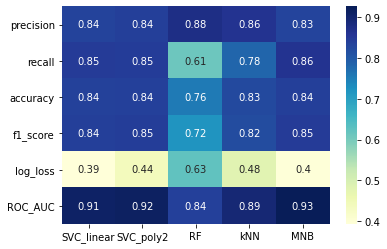

In [41]:
# HeatMap plot:

metrics_dict = defaultdict(dict)
threshold = 0.5

for name in model_names_arr:
    
    # Forming predicted class:
    predicted_class = (prob_pred_df[name] > threshold).astype(int)
    
    # Computing all metrics:
    precision, recall, f_score, _ = metrics.precision_recall_fscore_support(prob_pred_df['is_fake'],\
                                                                            predicted_class, average = 'binary')
    
    accuracy = metrics.accuracy_score(prob_pred_df['is_fake'], predicted_class)
    log_loss = metrics.log_loss(prob_pred_df['is_fake'], prob_pred_df[name])
    roc_auc = metrics.roc_auc_score(prob_pred_df['is_fake'], prob_pred_df[name])

    metric_name_value_pairs = zip(('precision', 'recall', 'accuracy', 'f1_score', 'log_loss', 'ROC_AUC'),\
                                  (precision, recall, accuracy, f_score, log_loss, roc_auc))
    
    # Building metrics dict:
    for metric_name, metric_value in metric_name_value_pairs:
        metrics_dict[name][metric_name] = metric_value

df_metrics = pd.DataFrame(metrics_dict)
sns.heatmap(df_metrics, cmap = 'YlGnBu', annot = True);

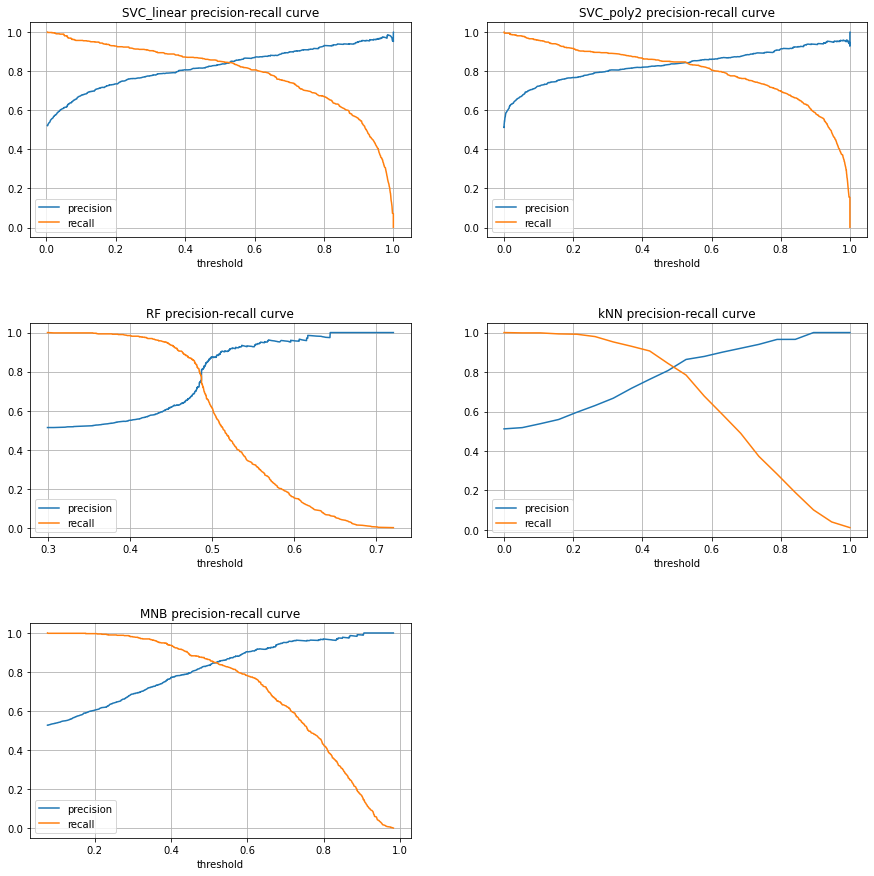

In [42]:
# Precision-recall curves:

fig = plt.subplots(figsize = (15, 15))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)

for i, name in enumerate(model_names_arr):
    
    precision, recall, threshold = metrics.precision_recall_curve(prob_pred_df['is_fake'],  prob_pred_df[name])
    plt.subplot(3, 2, i + 1)
    plt.plot(threshold, precision[:-1], label = 'precision')
    plt.plot(threshold, recall[:-1], label = 'recall')
    
    plt.xlabel('threshold')
    plt.title(f'{name} precision-recall curve')
    plt.legend()
    plt.grid()

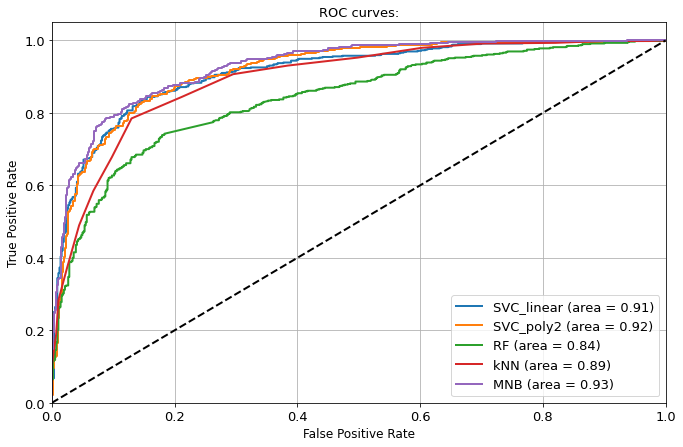

In [43]:
# Roc-curves:

fig = plt.subplots(figsize = (11, 7))

for name in model_names_arr:
    
    fpr, tpr, _ = metrics.roc_curve(prob_pred_df['is_fake'], prob_pred_df[name])
    roc_auc = metrics.roc_auc_score(prob_pred_df['is_fake'], prob_pred_df[name])
    plt.plot(fpr, tpr, lw = 2, label = f"{name} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)

plt.title('ROC curves:', fontsize = 13)
plt.legend(loc = 'best', fontsize = 13)
plt.grid()
plt.show()

---
# 7.Вывод:

 - Судя по HeatMap и AUC-ROC кривым из прошлого пункта, наилучшим оказался классификатор SVC с квадратичным ядром.


 - Стоит отметить, что значение кросс-энтропии у линейного классификатора оказалось ниже, чем у квадратичного. Однако поскольку ответ будет оцениваться по метрике F1 (а у квадратичного её значение выше) - решил выбрать именно кадратичный классификатор.

In [45]:
train_data = preprocessing(pd.read_csv('dataset/train.tsv', sep = '\t'))
test_data = preprocessing(pd.read_csv('dataset/test.tsv', sep = '\t'))

vectorizer = TfidfVectorizer()
train_x_vect = vectorizer.fit_transform(train_data['title'])

svc_clf = SVC(kernel = 'poly',
              degree =  gs_svc_poly.best_params_['degree'],
              C = gs_svc_poly.best_params_['C'], 
              random_state = rand_state)
svc_clf.fit(train_x_vect, train_data['is_fake'])

test_data['is_fake'] = svc_clf.predict(vectorizer.transform(test_data['title']))
test_data.to_csv('predictions.tsv', index = False, sep = '\t')